# miχPODS: New baseline


## TODO 

- [ ] why does the stability diagram load multiple times
- [ ] Is there an error in ONI phase labeling for the newer runs, presumably SST changed some.
- [ ] Add diagnostic for convective "adjustment" or `diff == 1`
- [ ] hvplot defaults
  - turn off scroll zoom
  - copy over presentation stuff
  
## Notes

This notebook compares:
1. TAO
1. "old" baseline with KD=1e-5, KV=2e-4 (https://github.com/NCAR/MOM6/issues/238)
1. old baseline + `kpp.lmd.004`  with `KPP ν0=2.5, Ric=0.2, Ri0=0.5`
1. new baseline : `KD=0, KV=0`
1. new baseline : `kpp.lmd.004`  with `KPP ν0=2.5, Ric=0.2, Ri0=0.5`
1. new baseline : `kpp.lmd.005`  with `KPP ν0=2.5, Ric=0.3, Ri0=0.5`

### Summary

1. Turning down the background visc by a factor of 40, (2e-4 → 5e-5 m2/s)
    1. sharpens the EUC relative to TAO
    1. changes the stability diagram for El-Nino warming phase.
2. Using `Ri_c=0.2`, so shallower KPP surface layer, is key as Dan mentioned.


## Setup

In [ ]:
%load_ext autoreload
%load_ext rich
%load_ext watermark

import math
import warnings

import cf_xarray as cfxr
import dcpy.datatree  # noqa
import distributed
import holoviews as hv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from datatree import DataTree

import xarray as xr

%aimport pump
from holoviews.plotting.bokeh.util import select_legends

from pump import mixpods

hv.notebook_extension("bokeh")

cfxr.set_options(warn_on_missing_variables=False)
xr.set_options(keep_attrs=True, display_expand_data=False)

plt.style.use("bmh")
plt.rcParams["figure.dpi"] = 140


%watermark -iv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


tqdm       : 4.65.0
distributed: 2023.3.2
cf_xarray  : 0.8.0
numpy      : 1.23.5
dcpy       : 0.1.dev387+gd06c937
holoviews  : 1.17.0
pump       : 1.0+273.g892024e.dirty
pandas     : 1.5.3
xarray     : 2023.3.0
sys        : 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
json       : 2.0.9
matplotlib : 3.7.1



In [ ]:
if "client" in locals():
    client.close()
    del client
if "cluster" in locals():
    cluster.close()

import ncar_jobqueue

cluster = ncar_jobqueue.NCARCluster(
    local_directory="/local_scratch/pbs.$PBS_JOBID/dask/spill",
)
cluster.adapt(minimum_jobs=1, maximum_jobs=4)
client = distributed.Client(cluster)
client

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44822 instead
  warnings.warn(


Client 
 Client-3d5fe538-2be7-11ee-8ec0-3cecef1aca66 
 

 
 
 Connection method: Cluster object 
 Cluster type: dask_jobqueue.PBSCluster 
 
 

 
 
 
 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/casper/proxy/44822/status 
 
 
 
 

 

 
 
 Launch dashboard in JupyterLab
 
 

 
 
 Cluster Info 
 
 
 
 
 PBSCluster 
 4da3fbc5 
 
 
 
 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/casper/proxy/44822/status 
 
 
 Workers: 0
 
 
 
 
 Total threads: 0
 
 
 Total memory: 0 B
 
 
 
 

 
 
 Scheduler Info 
 

 
 
 
 
 Scheduler 
 Scheduler-e1d11747-0a8e-4f5d-b66a-e5038efcb7fb 
 
 
 
 Comm: tcp://10.12.206.39:42965
 
 
 Workers: 0
 
 
 
 
 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/casper/proxy/44822/status 
 
 
 Total threads: 0
 
 
 
 
 Started: Just now
 
 
 Total memory: 0 B
 
 
 
 
 

 
 
 Workers

## Read

### Look at catalog

The catalog only contains surface variables, full depth variables, NO SECTIONS YET.

In [ ]:
catalog = pump.catalog.open_mom6_catalog()
catalog

pump-mom6-catalog catalog with 36 dataset(s) from 36 asset(s) : 

 
 
 
 
 unique 
 
 
 
 
 casename 
 10 
 
 
 stream 
 5 
 
 
 path 
 36 
 
 
 baseline 
 2 
 
 
 levels 
 2 
 
 
 frequency 
 3 
 
 
 variables 
 85 
 
 
 shortname 
 10 
 
 
 description 
 9 
 
 
 derived_variables 
 0

In [ ]:
import pandas as pd

catalog_sub = pd.concat(
    [
        cat.df
        for cat in [
            # pick two "old" baseline simulations
            catalog.search(
                stream="combined",
                levels=65,
                shortname=["baseline.001", "baseline.kpp.lmd.004"],
            ),
            # and all new baseline simulations
            catalog.search(stream="combined", levels=65, baseline="new"),
        ]
    ]
)

### backup

```python
catalog_sub = {
    k: catalog[k]
    for k in catalog.keys()
    if k == "kpp.lmd.004" or ("baseline" in k and "150" not in k)
}
display(catalog_sub)
```

```
{
    'baseline': ('baseline', 'gmom.e23.GJRAv3.TL319_t061_zstar_N65.baseline.001.mixpods'),
    'kpp.lmd.004': (
        'KPP ν0=2.5, Ric=0.2, Ri0=0.5',
        'gmom.e23.GJRAv3.TL319_t061_zstar_N65.baseline.kpp.lmd.004.mixpods'
    ),
    'new_baseline.hb': ('KD=0, KV=0', 'gmom.e23.GJRAv3.TL319_t061_zstar_N65.new_baseline.hb'),
    'new_baseline.kpp.lmd.004': (
        'KPP ν0=2.5, Ric=0.2, Ri0=0.5',
        'gmom.e23.GJRAv3.TL319_t061_zstar_N65.new_baseline.kpp.lmd.004.mixpods'
    ),
    'new_baseline.kpp.lmd.005': (
        'KPP ν0=2.5, Ri0=0.5',
        'gmom.e23.GJRAv3.TL319_t061_zstar_N65.new_baseline.kpp.lmd.005.mixpods'
    )
}
```

### Subset Catalog, build tree

In [ ]:
datasets = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    warnings.simplefilter("ignore", category=FutureWarning)
    for _, (casename, shortname, description) in tqdm.tqdm(
        catalog_sub[["casename", "shortname", "description"]].iterrows()
    ):
        datasets.update(
            {
                shortname: mixpods.load_mom6_sections(casename).assign_attrs(
                    {"title": description}
                )
            }
        )

5it [00:36,  7.28s/it]


In [ ]:
tree = DataTree.from_dict(datasets)
tree

<xarray.DatasetView>
Dimensions: ()
Data variables:
 *empty* datatree.DataTree Groups: (5) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.DatasetView>
Dimensions: (time: 533544, zi: 37, zl: 37, nv: 2)
Coordinates: (12/16)
 * nv (nv) float64 1.0 2.0
 * time (time) datetime64[ns] 1958-01-06T00:30:00 ... 2020-12-0...
 xh float64 -140.0
 yh float64 0.0625
 yq float64 -0.0625
 * zi (zi) float64 -523.8 -481.0 -442.5 ... -5.0 -2.5 -0.0
 ... ...
 oni (time) float32 nan nan nan nan ... -1.175 -1.175 -1.175
 en_mask (time) bool False False False False ... False False False
 ln_mask (time) bool False False False False ... True True True
 warm_mask (time) bool True True True True ... True True True True
 cool_mask (time) bool False False False False ... False False False
 enso_transition (time) <U12 '____________' ... 'La-Nina warm'
Data variables: (12/39)
 KPP_OBLdepth (time) float32 dask.array<chunksize=(533544,), meta=np.ndarray>
 KPP_buoyFlux (time, zi) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
 KPP_kheat (time, zi) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
 Kd_heat (time, zi) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
 Kv_u (time, zl) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
 Kv_v (time, zl) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
 ... ...
 ν (time, zl) float32 dask.array<chunksize=(8760, 37), meta=np.ndarray>
 shear_prod (time, zi) float32 dask.array<chunksize=(8760, 36), meta=np.ndarray>
 eps (time, zi) float32 dask.array<chunksize=(8760, 36), meta=np.ndarray>
 chi (time, zi) float32 dask.array<chunksize=(8760, 36), meta=np.ndarray>
 Rif (time, zi) float32 dask.array<chunksize=(8760, 36), meta=np.ndarray>
 sst (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
Attributes:
 title: baseline baseline.001 Groups: (0) Dimensions: time : 533544 zi : 37 zl : 37 nv : 2 Coordinates: (16) nv (nv) float64 1.0 2.0 cartesian_axis : N long_name : vertex number units : none array([1., 2.]) time (time) datetime64[ns] 1958-01-06T00:30:00 ... 2020-12-... array(['1958-01-06T00:30:00.000000000', '1958-01-06T01:30:00.000000000',
 '1958-01-06T02:30:00.000000000', ..., '2020-12-05T21:30:00.000000000',
 '2020-12-05T22:30:00.000000000', '2020-12-05T23:30:00.000000000'],
 dtype='datetime64[ns]') xh () float64 -140.0 cartesian_axis : X domain_decomposition : [220, 222, 220, 221] long_name : h point nominal longitude units : degrees_east array(-140.) yh () float64 0.0625 cartesian_axis : Y domain_decomposition : [210, 258, 210, 221] long_name : h point nominal latitude units : degrees_north array(0.06249997) yq () float64 -0.0625 cartesian_axis : Y domain_decomposition : [209, 257, 209, 221] long_name : q point nominal latitude units : degrees_north array(-0.06249997) zi (zi) float64 -523.8 -481.0 -442.5 ... -2.5 -0.0 cartesian_axis : Z long_name : Interface pseudo-depth, -z* positive : up units : meter array([-523.8 , -481.01, -442.51, -407.64, -375.88, -346.78, -319.99, -295.22,
 -272.22, -250.8 , -230.78, -212.02, -194.41, -177.85, -162.26, -147.57,
 -133.72, -120.66, -108.37, -96.83, -86.02, -75.94, -66.57, -57.91,
 -49.94, -42.66, -36.05, -30.1 , -24.81, -20.16, -16.15, -12.77,
 -10. , -7.5 , -5. , -2.5 , -0. ]) zl (zl) float64 -547.8 -502.4 ... -3.75 -1.25 cartesian_axis : Z long_name : Layer pseudo-depth, -z* positive : up units : meter array([-547.75 , -502.405, -461.76 , -425.075, -391.76 , -361.33 , -333.385,
 -307.605, -283.72 , -261.51 , -240.79 , -221.4 , -203.215, -186.13 ,
 -170.055, -154.915, -140.645, -127.19 , -114.515, -102.6 , -91.425,
 -80.98 , -71.255, -62.24 , -53.925, -46.3 , -39.355, -33.075,
 -27.455, -22.485, -18.155, -14.46 , -11.385, -8.75 , -6.25 ,
 -3.75 , -1.25 ]) eucmax (time) float64 dask.array<chunksize=(8760,), meta=np.ndarray> units : m long_name : EUC maximum positive : up 
 
 
 
 
 
 
 Array 
 Chunk 
 
 
 
 
 
 Bytes 
 4.07 MiB 
 68.44 kiB 
 
 
 
 Shape 
 (533544,) 
 (8760,) 
 
 
 Dask graph 
 61 chunks in 21 graph layers 
 
 
 Data type 

## Modify

In [ ]:
tao_gridded = mixpods.load_tao()
tree["TAO"] = DataTree(tao_gridded)

/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "depth" starting at index 42. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "time" starting at index 199726. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [ ]:
tree = tree.dc.reorder_nodes(["TAO", ...])

In [ ]:
datasets["les"] = les["0.0.-140.oct.average.month"].to_dataset()

# Offset LES to work with slicing below
datasets["les"]["time"] = datasets["les"]["time"] + pd.Timedelta(days=25 * 365)

In [ ]:
if "les" in tree:
    tree["les"] = tree["les"].isel(z=slice(-2))
    tree["les"]["KT"].attrs["standard_name"] = "ocean_vertical_heat_diffusivity"

if "micro" in locals():
    tree.update(micro)

### Post-process catalog subset

In [ ]:
tree = tree.sel(time=slice("2000", "2017"))
tree

<xarray.DatasetView>
Dimensions: ()
Data variables:
 *empty* datatree.DataTree Groups: (6) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <xarray.DatasetView>
Dimensions: (time: 157800, depth: 61, depthchi: 6)
Coordinates: (12/19)
 deepest (time) float64 dask.array<chunksize=(157800,), meta=np.ndarray>
 * depth (depth) float64 -300.0 -295.0 -290.0 ... -10.0 -5.0 0.0
 eucmax (time) float64 dask.array<chunksize=(98066,), meta=np.ndarray>
 latitude float32 0.0
 longitude float32 -140.0
 mld (time) float64 dask.array<chunksize=(157800,), meta=np.ndarray>
 ... ...
 oni (time) float32 -1.66 -1.66 -1.66 ... -0.87 -0.87 -0.87
 en_mask (time) bool False False False ... False False False
 ln_mask (time) bool True True True True ... True True True True
 warm_mask (time) bool False False False False ... True True True
 cool_mask (time) bool True True True True ... False False False
 enso_transition (time) <U12 'La-Nina cool' ... 'La-Nina warm'
Data variables: (12/39)
 N2 (time, depth) float64 dask.array<chunksize=(98066, 61), meta=np.ndarray>
 N2T (time, depth) float64 dask.array<chunksize=(98066, 61), meta=np.ndarray>
 Ri (time, depth) float64 dask.array<chunksize=(98066, 61), meta=np.ndarray>
 Rig_T (time, depth) float64 dask.array<chunksize=(98066, 61), meta=np.ndarray>
 S (time, depth) float64 dask.array<chunksize=(98066, 61), meta=np.ndarray>
 S2 (time, depth) float32 dask.array<chunksize=(98066, 61), meta=np.ndarray>
 ... ...
 Rig (time, depth) float64 dask.array<chunksize=(98066, 61), meta=np.ndarray>
 sst (time) float64 dask.array<chunksize=(98066,), meta=np.ndarray>
 Tflx_dia_diff (time, depthchi) float64 nan nan nan nan ... nan nan nan
 ν (time, depthchi) float64 dask.array<chunksize=(98066, 6), meta=np.ndarray>
 Jb (time, depthchi) float64 dask.array<chunksize=(98066, 6), meta=np.ndarray>
 Rif (time, depthchi) float64 dask.array<chunksize=(98066, 6), meta=np.ndarray>
Attributes:
 CREATION_DATE: 23:26 24-FEB-2021
 Data_Source: Global Tropical Moored Buoy Array Project O...
 File_info: Contact: Dai.C.McClurg@noaa.gov
 Request_for_acknowledgement: If you use these data in publications or pr...
 _FillValue: 1.0000000409184788e+35
 array: TAO/TRITON
 missing_value: 1.0000000409184788e+35
 platform_code: 0n165e
 site_code: 0n165e
 wmo_platform_code: 52321 TAO Groups: (0) Dimensions: time : 157800 depth : 61 depthchi : 6 Coordinates: (19) deepest (time) float64 dask.array<chunksize=(157800,), meta=np.ndarray> description : Deepest depth with a valid observation units : m 
 
 
 
 
 
 
 Array 
 Chunk 
 
 
 
 
 
 Bytes 
 1.20 MiB 
 1.20 MiB 
 
 
 
 Shape 
 (157800,) 
 (157800,) 
 
 
 Dask graph 
 1 chunks in 4 graph layers 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 157800 
 1 
 
 
 
 depth (depth) float64 -300.0 -295.0 -290.0 ... -5.0 0.0 axis : Z positive : up units : m array([-300., -295., -290., -285., -280., -275., -270., -265., -260., -255.,
 -250., -245., -240., -235., -230., -225., -220., -215., -210., -205.,
 -200., -195., -190., -185., -180., -175., -170., -165., -160., -155.,
 -150., -145., -140., -135., -130., -125., -120., -115., -110., -105.,
 -100., -95., -90., -85., -80., -75., -70., -65., -60., -55.,
 -50., -45., -40., -35., -30., -25., -20., -15., -10., -5.,
 0.]) eucmax (time) float64 dask.array<chunksize=(98066,), meta=np.ndarray> units : m long_name : EUC maximum positive : up 
 
 
 
 
 
 
 Array 
 Chunk 
 
 
 
 
 
 Bytes 
 1.20 MiB 
 766.14 kiB 
 
 
 
 Shape 
 (157800,) 
 (98066,) 
 
 
 Dask graph 
 2 chunks in 18 graph layers 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 157800 
 1 
 
 
 
 latitude () float32 0.0 array(0., dtype=float32) longitude () float32 -140.0 array(-140., dtype=float32) mld (time) float64 dask.array<chunksize=(157800,), meta=np.ndarray> long_name : $z_{MLD}$ units : m 
 
 
 


In [ ]:
ref = tree["TAO"].ds.reset_coords(drop=True).cf.sel(Z=slice(-120, None))
counts = np.minimum(ref["S2"].cf.count("Z"), ref["N2T"].cf.count("Z")).load()


def calc_histograms(ds):
    ds = ds.copy()
    ds["tao_mask"] = counts.reindex(time=ds.time, method="nearest") > 5
    ds["tao_mask"].attrs = {
        "description": "True when there are more than 5 5-m T, u, v in TAO dataset"
    }
    # I did try masking out the model like the data
    # ds = ds.where(ds.tao_mask)
    return ds.update(mixpods.pdf_N2S2(ds))


tree = tree.map_over_subtree(calc_histograms)

### daily composite

In [ ]:
dailies = tree.map_over_subtree(mixpods.daily_composites)
dailies

### seasonal cycle

### Persist tree

In [ ]:
tree = mixpods.persist_tree(tree)

### Validate before continuing

In [ ]:
mixpods.validate_tree(tree)

## Mean profiles

### State Variables

1. A lot more shear, $S, S^2$ just above the EUC when visc is turned down!
2. We are very slightly lower on $S^2$, $N_T^2$ in the top 80m, compare `TAO`, `kpp.lmd.004`, `new_baseline.kpp.lmd.004`.
3. Using the standard `Ri_c=0.3`, so deeper KPP surface layer, decreases $S^2$, $N_T^2$ in the top 60m. `new_baseline.kpp.lmd.004` vs `new_baseline.kpp.lmd.005`




for context, Peters et al (1995) is interesting:
> 1. Variability patterns at 50-350 m are distinctly different from the upper 50 m containing the diurnal cycle of mixing
> 1. Large-scale shear of wavenumbers k < 0.01 cpm is associated with the slowly varying EUC and EIC. Large-scale is the dominant component of total shear above 50 m and in the thermostad, 170-270 m.
> 1. Fine-scale shear, 0.01cpm < k  < 0.5 cpm,provides the dominant component of total rms shear and exceeds the large-scale component in thick layersaroundthe coresof EUC and EIC, where Fr < 1, at 50-170 m and below 270 m. 
> 1.  Variations of fine-scale shear cause variations in turbulent mixing; the large-scaleshear alone is a poor predictor of mixing.
> 1. Lacking a model that links large-scale, fine-scale, and turbulent flow components,our service to equatorial modelers consists of describing general levels of eddy diffusivities and their variability patterns.

These models *should* not be resolving "finescale" shear, and the mixing is not well correlated with "large-scale shear", so we need a "background" diffusivity/viscosity to make things work.

But see that std($S^2$) is a **lot** stronger above the EUC core, relative to TAO for `new_baseline.kpp.lmd.004` and `new_baseline.kpp.lmd.005`

In [ ]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%autoreload

S2 = mixpods.plot_profile_fill(tree, "S2", "S^2")
N2 = mixpods.plot_profile_fill(tree, "N2T", "N_T^2")
u = mixpods.plot_profile_fill(tree, "sea_water_x_velocity", "u")
T = mixpods.plot_profile_fill(tree, "sea_water_potential_temperature", "T")
Ri = mixpods.plot_median_Ri(tree)

In [ ]:
%xmode minimal

Exception reporting mode: Minimal


In [ ]:
%autoreload

plot = (
    (S2 + N2 + Ri + u + T)
    .cols(5)
    .opts(
        hv.opts.Curve(xlim=(-350, 0), frame_height=600),
        hv.opts.Layout(toolbar="left"),
        hv.opts.Overlay(legend_offset=(0, 200)),
        clone=True,
    )
)
select_legends(plot, figure_index=4, legend_position="right")

### Turbulence Variables

In [ ]:
mixpods.map_hvplot(
    lambda ds, name, muted: ds.ds.cf["ocean_vertical_heat_diffusivity"]
    .mean("time")
    .hvplot.line(label=name, muted=muted),
    tree,
).opts(
    ylim=(1e-8, 1e1),
    legend_position="right",
    logx=True,
    invert_axes=True,
    frame_width=300,
    aspect=1 / 3,
)

In [ ]:
mixpods.map_hvplot(
    lambda ds, name, muted: ds["eps"]
    .mean("time")
    .load()
    .hvplot.line(label=name, muted=muted),
    tree,
).opts(
    ylim=(1e-10, None),
    legend_position="right",
    logx=True,
    invert_axes=True,
    frame_width=300,
    aspect=1 / 3,
)

In [ ]:
mixpods.map_hvplot(
    lambda ds, name, muted: ds.ds.cf["ocean_vertical_heat_diffusivity"]
    .mean("time")
    .load()
    .hvplot.line(label=name, muted=muted),
    tree,
).opts(
    ylim=(1e-8, 1e1),
    legend_position="right",
    logx=True,
    invert_axes=True,
    frame_width=300,
    aspect=1 / 3,
)

## ENSO Phases

### Stability Diagram

1. Major change in La-Nina Warming for the new-baseline runs. We need to check ONI closely.

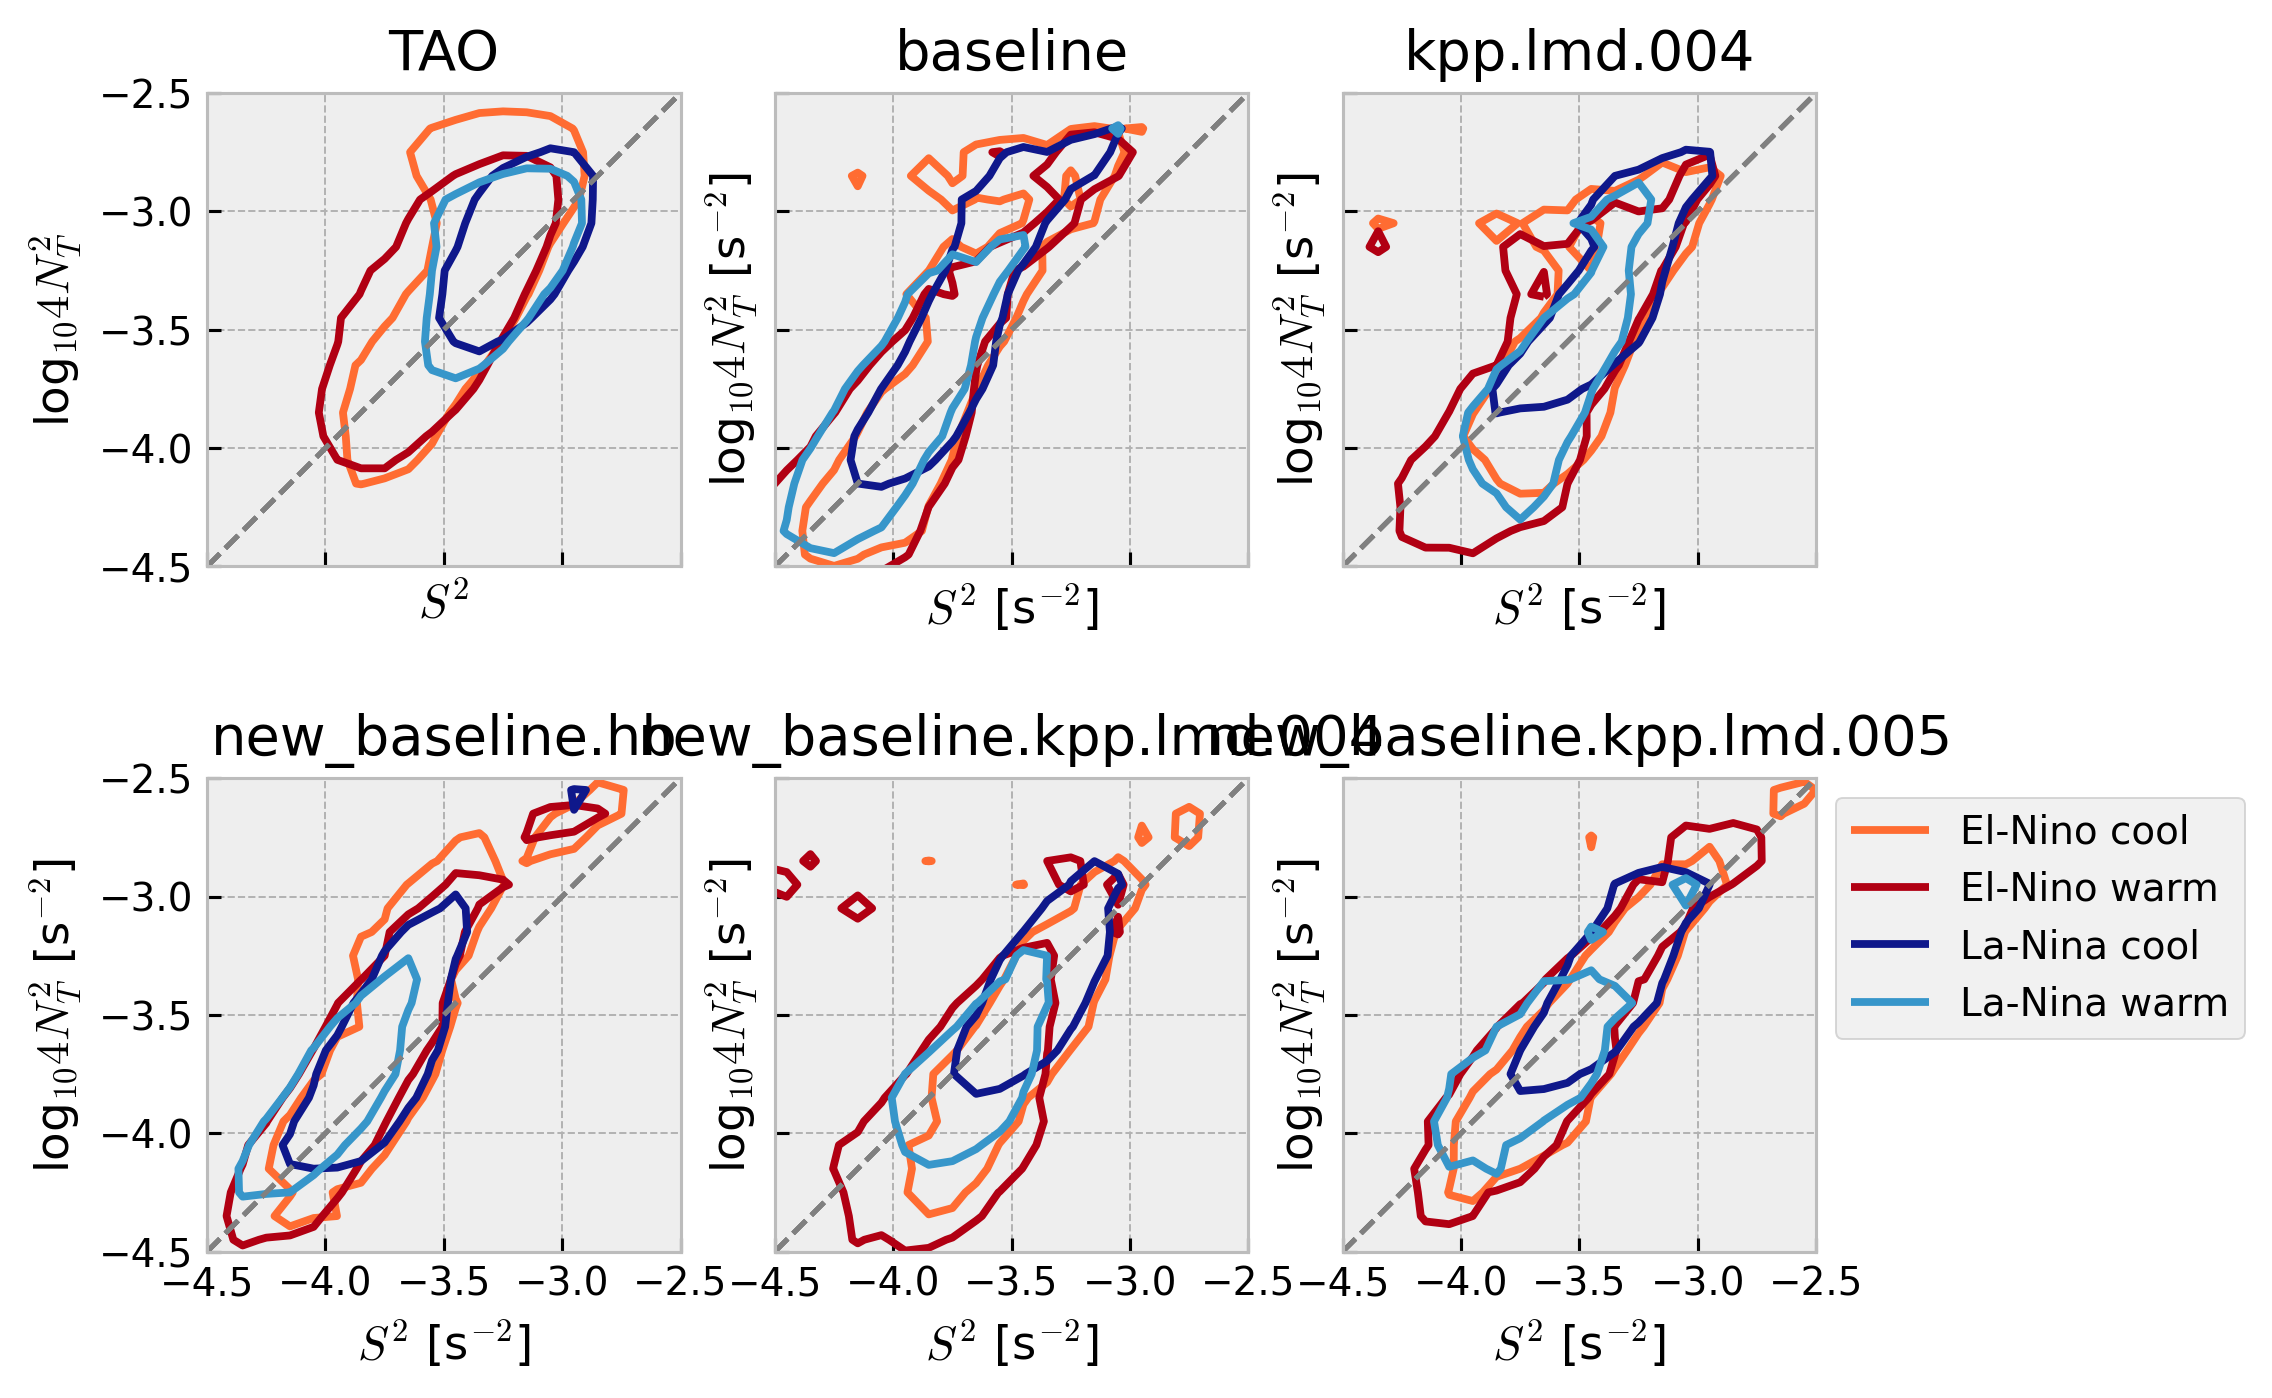

In [ ]:
%autoreload

mixpods.plot_stability_diagram_by_dataset(tree, nrows=2)

### ε-Ri histograms

In [ ]:
%autoreload

mixpods.map_hvplot(
    lambda dt, name, muted: mixpods.plot_eps_ri_hist(
        dt["eps_ri"].load(), label=name, muted=muted
    ),
    tree.children,
).opts(
    hv.opts.Curve(ylim=(1e-8, 3e-6)),
    hv.opts.GridSpace(show_legend=True),
    hv.opts.Overlay(show_grid=True, legend_position="bottom_left"),
    *mixpods.HV_TOOLS_OPTIONS,
)

## Daily composites

Hard to interpret! I think a lot of this is bias in KPP surface layer vs actively  mixing layer in obs.  We can write better diagnostics  to check this (Moum et  al, 2023)

1. The 89m χpod comparison is quite interesting. Suggests we do need more background visc

In [ ]:
plot

In [ ]:
%autoreload

plot = mixpods.plot_daily_composites(dailies, ["eps"], logy=True)
plot.opts(toolbar="left", show_legend=True)

In [ ]:
%autoreload

mixpods.plot_daily_composites(
    dailies, ["S2", "N2", "Rig_T"], logy=False, legend=False
).opts(hv.opts.GridSpace(show_legend=True, width=200), hv.opts.Overlay(frame_width=200))

## Turbulence distributions

In [ ]:
handles = [
    mixpods.plot_distributions(tree, "chi", bins=np.linspace(-11, -4, 101), log=True),
    mixpods.plot_distributions(tree, "eps", bins=np.linspace(-11, -4, 101), log=True),
    mixpods.plot_distributions(
        tree, "ocean_vertical_heat_diffusivity", bins=np.linspace(-8, -1, 101), log=True
    ),
    # plot_distributions(tree, "Jq", bins=np.linspace(-1000, 0, 51), log=False),
    mixpods.plot_distributions(tree, "Rig_T", np.linspace(-0.5, 1.5, 61))
    * hv.VLine(0.25).opts(line_color="k"),
]

In [ ]:
plot = (
    hv.Layout(handles)
    .opts("Overlay", frame_width=500)
    .cols(2)
    .opts(*mixpods.HV_TOOLS_OPTIONS)
)
select_legends(plot, figure_index=1, legend_position="right")

### Compare boundary layer depth

In [ ]:
mixing_layer_depth_criteria = {
    "boundary_layer_depth": {"name": "KPPhbl|KPP_OBLdepth|ePBL_h_ML"},
}

hbl = (
    tree.drop_nodes("TAO")
    .dc.subset_nodes("KPP_OBLdepth")
    .dc.concatenate_nodes()
    .reset_coords(drop=True)
).load()

In [ ]:
(
    # hbl.groupby("time.hour").mean().hvplot.line(by="node", flip_yaxis=True)
    hbl.groupby("time.hour")
    .mean()
    .hvplot.line(by="node", flip_yaxis=True)
    .opts(show_legend=False)
    + hbl.to_dataframe().hvplot.hist(
        by="node",
        bins=np.arange(0, 90, 1),
        normed=1,
        alpha=0.3,
        ylim=(0, 0.05),
        muted_alpha=0,
    )
).opts(
    hv.opts.Curve(invert_yaxis=True),
    *mixpods.HV_TOOLS_OPTIONS,
    *mixpods.PRESENTATION_OPTS,
)

## Heat Budget

In [ ]:
f, ax = plt.subplots(
    2,
    math.ceil(len(tree) / 2),
    constrained_layout=True,
    squeeze=False,
    sharex=True,
    sharey=True,
    figsize=(10, 3),
)

for axx, (name, node) in zip(ax.flat, tree.children.items()):
    mixpods.plot_climo_heat_budget_1d(node.ds, mxldepth=-40, penetration="mom", ax=axx)
    axx.set_title(name)

dcpy.plots.clean_axes(ax)